In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import shap
from shap import maskers
import kagglehub


2025-05-04 05:30:18.000192: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 05:30:18.239600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746325818.332559  116923 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746325818.361959  116923 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 05:30:18.584645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Download dataset
dataset_path = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Dataset downloaded to:", dataset_path)
data_dir = os.path.join(dataset_path, "Data")

Dataset downloaded to: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1
Dataset downloaded to: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1


In [4]:
# Configuration
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 5

In [5]:
# Define 4-class mapping
CLASS_MAPPING = {
    "Non Demented": "CN",
    "Very mild Dementia": "MCI",
    "Mild Dementia": "Mild_AD",
    "Moderate Dementia": "Moderate_AD"
}

In [6]:
def preprocess_image(image):
    """Enhanced preprocessing for medical images"""
    # Convert to RGB if grayscale
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Apply unsharp masking with valid Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 1.0)
    image = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    
    return image

In [7]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    validation_split=0.2,
    preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [8]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(CLASS_MAPPING.keys())
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(CLASS_MAPPING.keys())
)

Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.


In [9]:
# Verify class indices
print("\nClass Indices:", train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())


Class Indices: {'Non Demented': 0, 'Very mild Dementia': 1, 'Mild Dementia': 2, 'Moderate Dementia': 3}


In [10]:
# Model Architecture
def create_model():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer=RMSprop(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

I0000 00:00:1746325828.793820  116923 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,401,156 (81.64 MB)

 Trainable params: 6,686,468 (25.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# Class weights
class_counts = {cls: sum(train_generator.classes == idx) 
               for cls, idx in train_generator.class_indices.items()}
total_samples = sum(class_counts.values())
class_weights = {
    idx: total_samples/(len(class_counts)*count) 
    for cls, (idx, count) in zip(class_counts.keys(), class_counts.items())
}
print("\nClass Weights:", class_weights)


Class Weights: {'Non Demented': np.float64(0.3214650972516642), 'Very mild Dementia': np.float64(1.574476320582878), 'Mild Dementia': np.float64(4.319777611194403), 'Moderate Dementia': np.float64(44.21419437340153)}


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=7),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ])

/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1746325832.395336  117166 service.cc:148] XLA service 0x7faed0022cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746325832.395810  117166 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-05-04 05:30:32.501592: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746325832.807133  117166 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2161 ━━━━━━━━━━━━━━━━━━━━ 1:54 53ms/step - accuracy: 0.4219 - loss: 1.4217  

I0000 00:00:1746325840.622450  117166 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2161/2161 ━━━━━━━━━━━━━━━━━━━━ 530s 241ms/step - accuracy: 0.7482 - loss: 0.7746 - val_accuracy: 0.7688 - val_loss: 0.6210 - learning_rate: 1.0000e-05
Epoch 2/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 488s 226ms/step - accuracy: 0.7764 - loss: 0.5992 - val_accuracy: 0.7529 - val_loss: 0.6080 - learning_rate: 1.0000e-05
Epoch 3/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 440s 204ms/step - accuracy: 0.7839 - loss: 0.5605 - val_accuracy: 0.7574 - val_loss: 0.6086 - learning_rate: 1.0000e-05
Epoch 4/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 431s 199ms/step - accuracy: 0.7833 - loss: 0.5369 - val_accuracy: 0.7537 - val_loss: 0.6146 - learning_rate: 1.0000e-05
Epoch 5/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 408s 189ms/step - accuracy: 0.7901 - loss: 0.5227 - val_accuracy: 0.7475 - val_loss: 0.6139 - learning_rate: 1.0000e-05


In [13]:
# Visualization functions (same as before)
def plot_history(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(10, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def plot_roc_curve(y_true, y_score, class_names):
    """Plot ROC curves for each class"""
    # Binarize the output
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (AUC = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
                    cbar=False, square=True, 
                    xticklabels=class_names, 
                    yticklabels=class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j+0.5, i+0.3, f"{cm[i, j]}", 
                   ha='center', va='center', color='black')
    plt.title('Confusion Matrix (%) with Counts', pad=20, fontsize=16)
    plt.xlabel('Predicted Label', labelpad=15)
    plt.ylabel('True Label', labelpad=15)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [16]:
def explain_with_lime(model, image, class_names, top_labels=4):
    explainer = lime_image.LimeImageExplainer()
    if image.max() > 1.0:
        image = image / 255.0
    explanation = explainer.explain_instance(
        image.astype('double'), 
        lambda x: model.predict(x, verbose=0),
        top_labels=top_labels,
        hide_color=0,
        num_samples=1000)
    fig, axes = plt.subplots(1, top_labels, figsize=(20, 5))
    if top_labels == 1:
        axes = [axes]
    for i, class_idx in enumerate(explanation.top_labels):
        temp, mask = explanation.get_image_and_mask(
            class_idx,
            positive_only=True,
            num_features=5,
            hide_rest=False)
        axes[i].imshow(mark_boundaries(temp, mask))
        axes[i].set_title(f"Explanation for {class_names[class_idx]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
# Evaluation
def evaluate_model(model, generator):
    y_true = generator.classes
    y_prob = model.predict(generator)
    y_pred = np.argmax(y_prob, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    plot_roc_curve(y_true, y_prob, class_names)
    plot_confusion_matrix(y_true, y_pred, class_names)
    sample_images, _ = next(generator)
    for i in range(min(3, len(sample_images))):
        print(f"\nExplanation for sample {i+1}:")
        explain_with_lime(model, sample_images[i], class_names)


Training History:


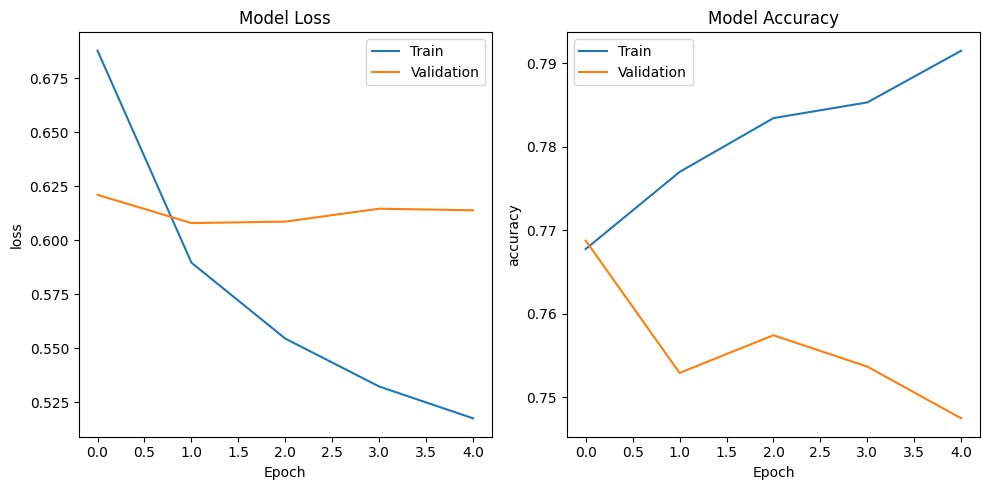


Validation Set Evaluation:
541/541 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step

Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.81      0.92      0.86     13444
Very mild Dementia       0.29      0.21      0.24      2745
     Mild Dementia       0.21      0.02      0.04      1000
 Moderate Dementia       0.00      0.00      0.00        97

          accuracy                           0.75     17286
         macro avg       0.33      0.29      0.28     17286
      weighted avg       0.69      0.75      0.71     17286



/home/helal/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helal/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helal/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


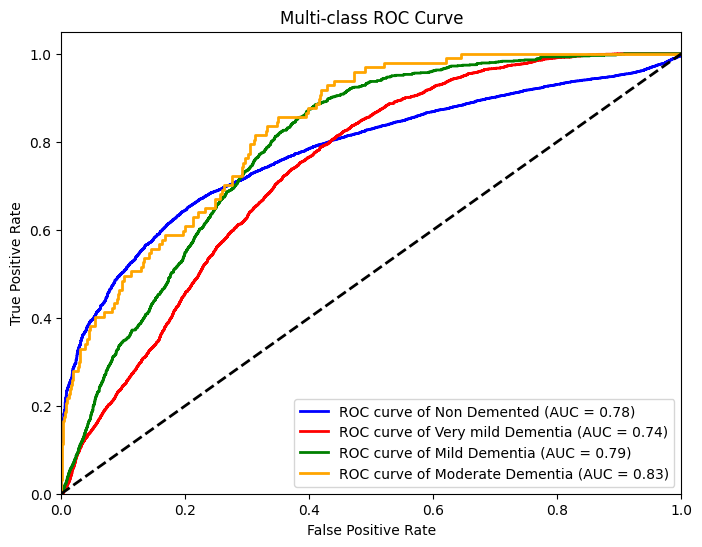

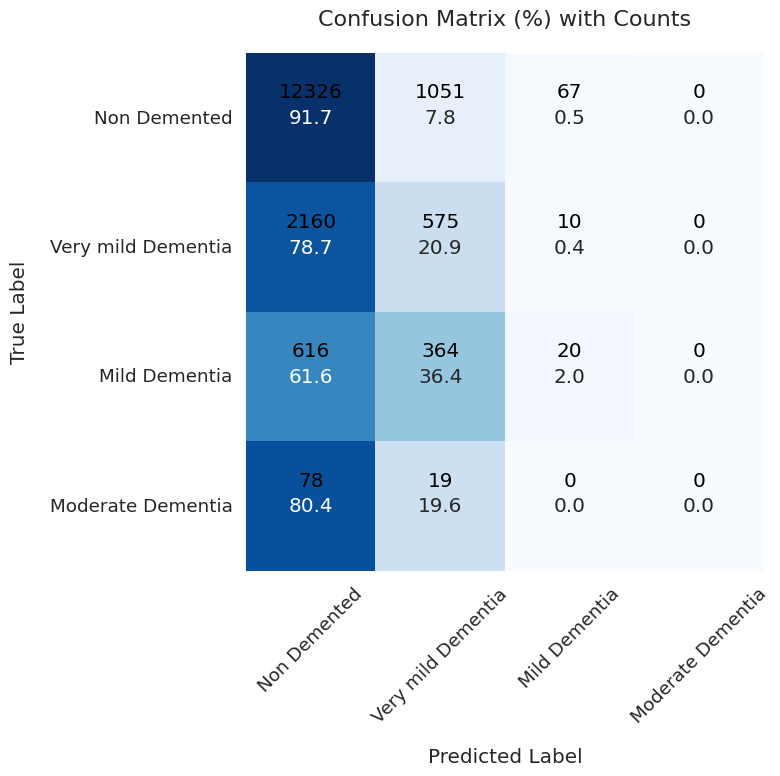


Explanation for sample 1:


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.29it/s]


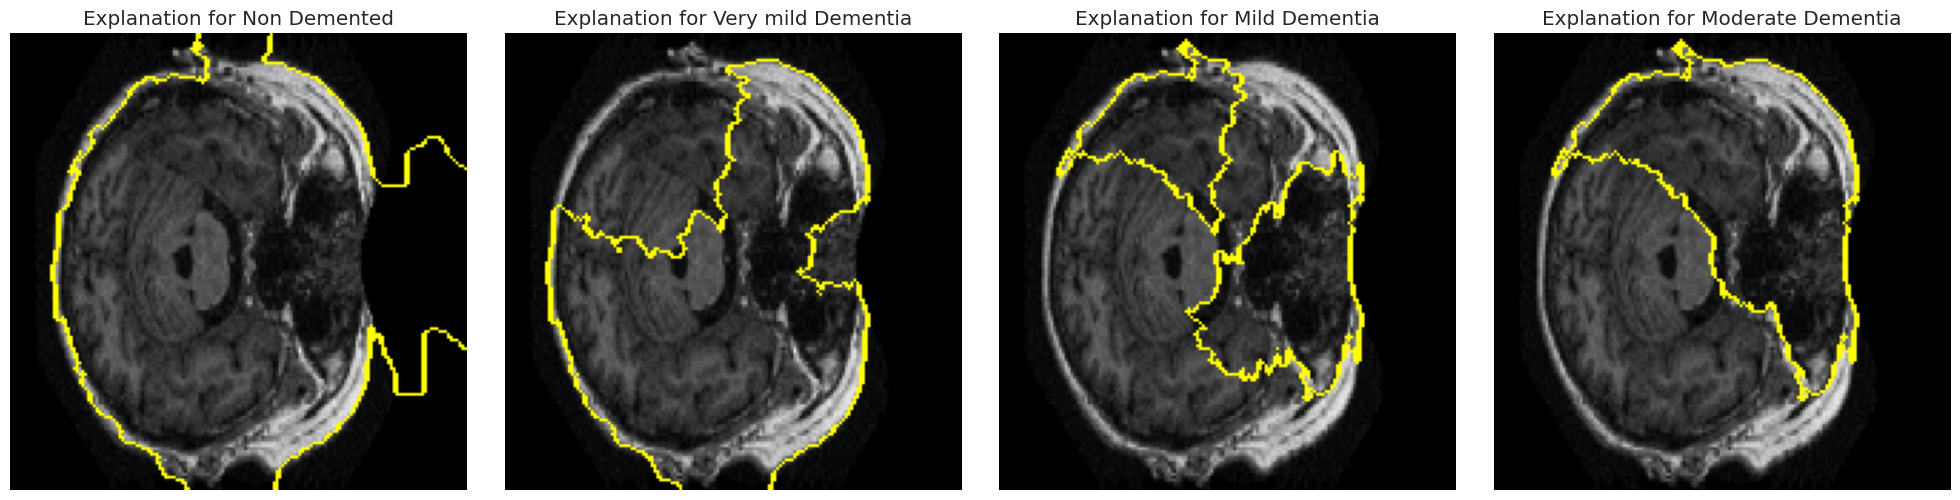


Explanation for sample 2:


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.25it/s]


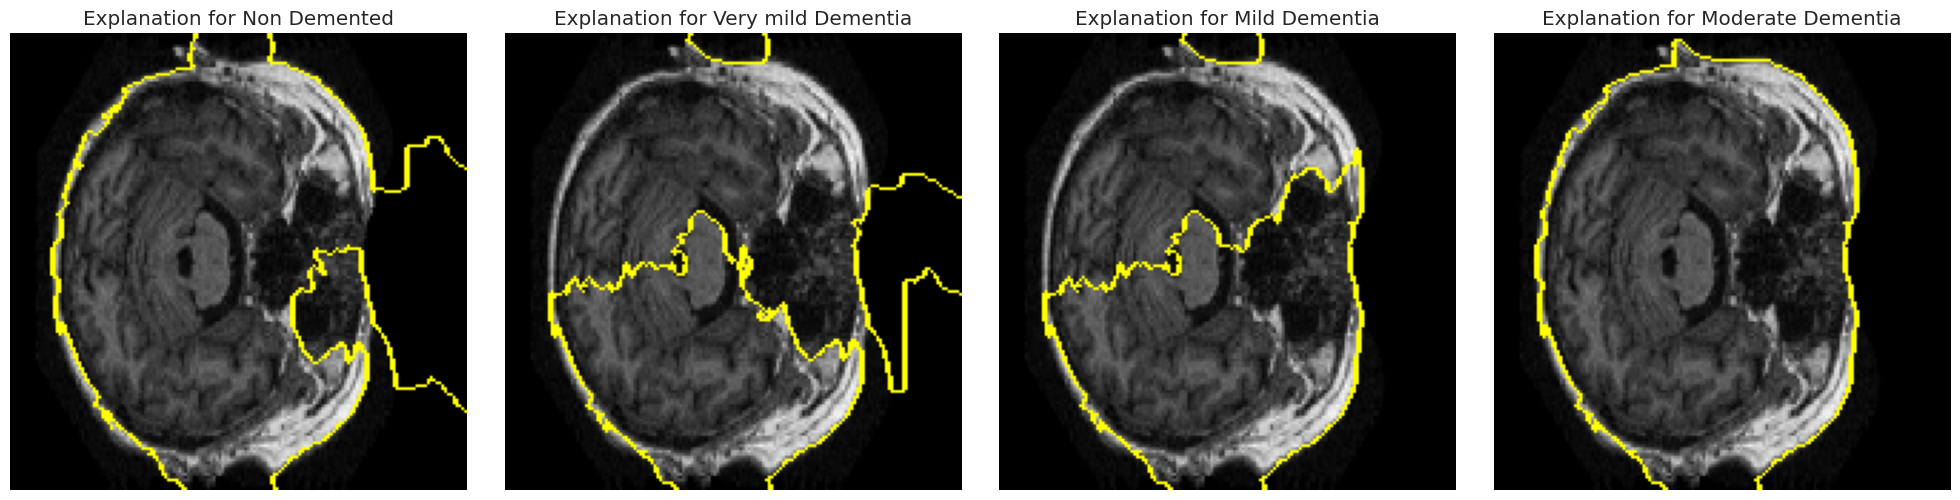


Explanation for sample 3:


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.92it/s]


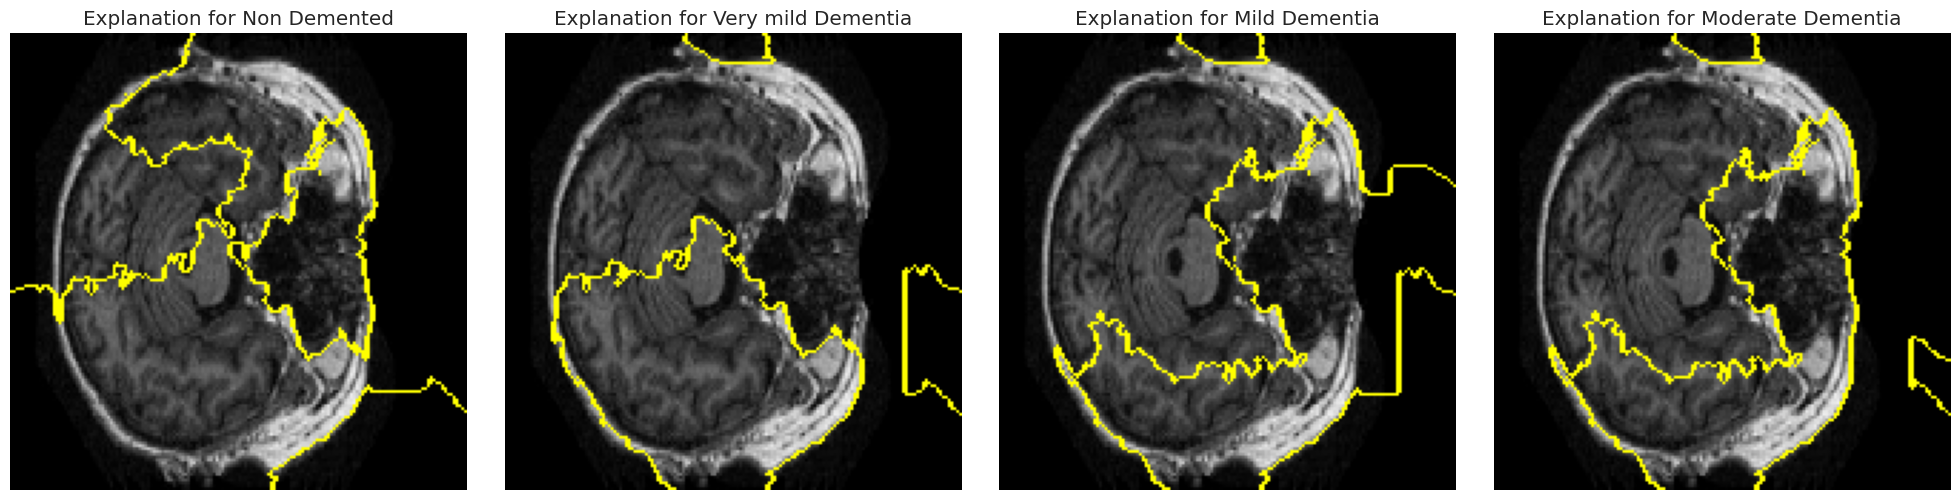

In [18]:
# Run evaluation
print("\nTraining History:")
plot_history(history)

print("\nValidation Set Evaluation:")
evaluate_model(model, val_generator)